# Fit Model


In [1]:
import pandas as pd
import mlutils
from sklearn import svm, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
# column names
feature_col = "features" # feature vector
value_col = "foldType" # fold type to be predicted

### Read data set with fold type classifications and feature vectors

In [3]:
df = pd.read_json("./features.json")

In [4]:
print("Total number of data:", df.shape[0])
df.head(2)

Total number of data: 10713


,Exptl.,FreeRvalue,R-factor,alpha,beta,coil,features,foldType,length,ngram,pdbChainId,resolution,secondary_structure,sequence
0,XRAY,0.29,0.16,0.345455,0.206061,0.448485,"[0.070844379, -0.050816530900000004, -0.191118...",alpha+beta,330,"[MK, KT, TA, AY, YI, IA, AK, KQ, QR, RQ, QI, I...",12AS.A,2.2,CCCCHHHHHHHHHHHHHHHHHHHHHHHCEEECCCCSEEETTSSCSC...,MKTAYIAKQRQISFVKSHFSRQLEERLGLIEVQAPILSRVGDGTQD...
1,XRAY,0.26,0.19,0.469945,0.046448,0.483607,"[0.11704757930000001, 0.14817539700000001, -0....",alpha,366,"[SR, RM, MP, PS, SP, PP, PM, MP, PV, VP, PP, P...",16VP.A,2.1,CCSCCCCCCCCHHHHHHHHHHHHTCTTHHHHHHHHHHCCCCCSTTS...,SRMPSPPMPVPPAALFNRLLDDLGFSAGPALCTMLDTWNEDLFSAL...


## Balance dataset

This dataset if highly imbalanced. The alpha+beta class is over-represented and the beta class is underrepresented.

In [5]:
df[value_col].value_counts()

alpha+beta    7030
alpha         2810
beta           873
Name: foldType, dtype: int64

Here we balance the dataset by downsampling the over-represented classes. Samples are randomly choose from the over-represented classes. We use a fixed random number seed so the downsampling step is reproducible.

In [6]:
df = mlutils.downsample(df, value_col, seed=13)
df[value_col].value_counts()

alpha+beta    873
beta          873
alpha         873
Name: foldType, dtype: int64

## Split dataset into a training and test set

In [7]:
train, test = train_test_split(df, test_size=0.33, random_state=13, stratify=df[value_col])
print("Train set size:", train.shape[0])
print(train[value_col].value_counts())
print()
print("Test set size:", test.shape[0])
print(test[value_col].value_counts())
train.head(2)

Train set size: 1754
alpha         585
alpha+beta    585
beta          584
Name: foldType, dtype: int64

Test set size: 865
beta          289
alpha         288
alpha+beta    288
Name: foldType, dtype: int64


,Exptl.,FreeRvalue,R-factor,alpha,beta,coil,features,foldType,length,ngram,pdbChainId,resolution,secondary_structure,sequence
9427,XRAY,0.21,0.17,0.000000,0.423077,0.576923,"[-0.14773577770000001, -0.1167704432, -0.30280...",beta,104,"[SE, ER, RP, PS, SP, PP, PV, VN, NL, LT, TS, S...",4O00.A,1.853,CCCCCCCEEEEEECCCSSEEEEEEECCSCCTTSCCCEEEEEEEETT...,SERPSPPVNLTSSDQTQSSVQLKWEPPLKDGGSPILGYIIERCEEG...
13457,XRAY,0.29,0.23,0.761905,0.027778,0.210317,"[-0.0765513835, -0.2019394528, 0.254880272, 0....",alpha,252,"[MS, SN, NM, MK, KK, KD, DT, TN, NE, EI, IV, V...",6BR8.A,2.300,CCCCHHHHHHHHHHHHHHHHHHHHHHTCSSHHHHHHHHHHTHHHHH...,MSNMKKDTNEIVQDLKKILGIVSLIKSANNEHQAYKILMENNSFII...


## Train a classifier

In [8]:
classifier = svm.SVC(gamma='auto')
#classifier = LogisticRegression()
#classifier = RandomForestClassifier()

classifier.fit(train[feature_col].tolist(), train[value_col].tolist())

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

## Make prediction for test set

In [9]:
predicted = classifier.predict(test[feature_col].tolist())
expected = test[value_col].tolist()

## Calculate metrics for test set

Classification metrics:

             precision    recall  f1-score   support

      alpha       0.79      0.67      0.73       288
 alpha+beta       0.62      0.67      0.64       288
       beta       0.77      0.83      0.80       289

avg / total       0.73      0.72      0.72       865



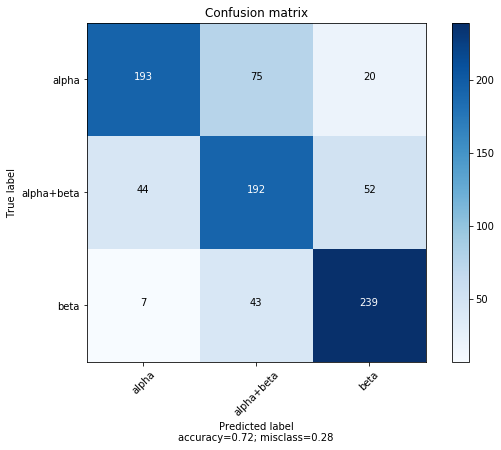

In [10]:
cm = metrics.confusion_matrix(expected, predicted)
print("Classification metrics:\n")
print(metrics.classification_report(expected, predicted))
mlutils.plot_confusion_matrix(cm, classifier.classes_, normalize=False)